# DeepAttSeq

## Requirement

*  <font size=3>Anaconda : 4.8.4
*  <font size=3>argparse : 1.4.0
*  <font size=3>keras : 2.3.1
*  <font size=3>matplotlib : 3.1.3
*  <font size=3>numpy : 1.18.1
*  <font size=3>pandas : 1.0.4
*  <font size=3>pyfasta : 0.5.2
*  <font size=3>python : 3.7.7
*  <font size=3>scikit-learn : 0.22.1
*  <font size=3>scipy : 1.4.1
*  <font size=3>tensorflow : 2.2.0

## Data Preprocessing

<font size=3>Previous studies have demonstrated the correlation between the mammalian m6A site and the DRACH consensus sequence. 'D' represents 'A, G, or U.' 'R' represents 'A or G.' 'H' represents 'A, C, or U.' 'A' is the m6A modification site. However, the DRACH sequence is too common in the genome to be a taxonomy of the m6A site. Therefore, we first screened out fragments containing DRACH sequences and defined RNA sequence R in the sample as follows:

$$R_{\eta}(DRACH)=N_{-\eta}N_{-(\eta-1)}...N_{-3}DRACHN_{3}...N_{\eta-1}N_{\eta}$$

<font size=3>In the formula, N denotes the nucleotide, and $\eta$ represents the relative position.

<font size=3>For the positive samples, screen out the sites conforming to DRACH, then clip out RNA sequences of a certain length centering on DRACH. For the negative samples, screen out the sites conforming to DRACH, but the base A is not the methylation modification site, then clip out these sequences as the positive samples do. Previous studies and experimental verification show that the model achieves the best performance when $\eta=50$ and the length of the RNA sequence sample is 101bp.

### Step1: Get the positive and negative samples

### Step2: Remove redundancy and acquire secondary structure

<font size=3>CD-HIT-EST clusters a nucleotide dataset into clusters that meet a user-defined similarity threshold, usually a sequence identity.  The input is a DNA/RNA dataset in fasta format and the output are two files: a fasta file of representative sequences and a text file of list of clusters.<br>
Since eukaryotic genes usually have long introns, which cause long gaps, it is difficult to make full-length alignments for these genes. So, CD-HIT-EST is good for non-intron containing sequences like EST.

<font size=3>After obtaining the sample sequence of RNA, it also needs to conduct corresponding pretreatment to convert the sequence data into vectors that the model can understand. After obtaining both positive and negative samples centered on DRACH, to avoid the impact of redundant data on model training and evaluation, we used the CD-HIT-EST toolkit to remove redundancy from all sample data. If a sample has a high sequence similarity with another sample, it will be removed. Otherwise, it will be retained. After referring to his previous studies, the threshold is set as 80%.

In [ ]:
cd-hit-est -i data.fa -o cdhit_data.fa -c 0.8 -n 5 -M 16000 -d 0 -T 8

<font size=3>The secondary structure of the sample sequence can be obtained by using the RNAfold package. The prediction results not only give the planar diagram of the secondary structure of the RNA sequence, but also give the dot-bracket representation of the secondary structure. This method uses "(",") "and"." to represent the different components of the secondary structure, where dots are used to represent a single base that does not form complementary pairs with other bases, and brackets are used to represent two bases that form complementary pairs.

In [ ]:
RNAfold -p < cdhit_data.fa > RNAfold_data.txt

### Step3: one-hot coding

<font size=3>**Binary encoding of nucleotide sequence positions (binary encoding)**. For the sequence information of RNA, base A is represented as [1,0,0,0], U is represented as [0,1,0,0], and C and G are represented as [0,0,1,0] and [0,0,0,1] respectively. After encoding, the RNA sequence with length of 101bp is represented as a vector of $101\times4$.

<font size=3>**Secondary structure information encoding**. In the study, besides considering sequence information, secondary structure information is also introduced. Sample sequence of secondary structure can be predicted through the RNAfold packages. The prediction results not only give the planar diagram of the secondary structure of the RNA sequence, but also give the dot parenthesis representation of the secondary structure. This method uses ") ", " ("and "." to represent different components of the secondary structure, where dots are used to represent a single base that does not form a complementary pairing with another base, and parentheses are used to represent two bases that form a complementary pairing. For the secondary structure information, it’s encoded as a $101\times3$ vector by means of dot parenthesis notation, where "(" is encoded as [1,0,0], ") "is encoded as [0,1,0], ". " is [0,0,1].

<font size=3>sequence & structure one-hot coding

### Step4: Seperate the training set and test set

<font size=3>Then the data was shuffled, 10% of which was randomly selected as the test set, and the rest data was selected as the training set and the verification set in the model training process, with a ratio of 8:2 between them.

## Model training

In model construction, it is necessary to determine the number of one-dimensional convolution layers at first. Generally speaking, the more convolution layers, the more parameters will be increased, and more features can be extracted. However, with the increase in the number of layers, the amount of computation will become more extensive, and the model is more prone to overfitting. In this model, we chose two convolution layers. In order to improve the model performance and prevent overfitting, the batch standardization layer and Dropout layer are added to the convolution layer, respectively. The activation function for CNN layers is the rectified linear unit (ReLU). The binary cross entropy is used as the loss function to measure the difference between the targets, and Adam is used as the optimizer.<br>
In addition to exploring how to build a suitable network structure, this paper also considers the model's input. The model performance is often better with high-quality inputs that contain essential information. Previous studies have shown that introducing secondary structure information can improve the classification effect of the model. Therefore, in addition to the basic RNA sequence information, the secondary structure information is also considered. In order to input these two kinds of information simultaneously, the study referred to the DeepCpG model. It modified the model structure into a double-input model, thus determining the final structure of the model. In the Seq and Str modules, the one-hot encoded RNA sequences and secondary structures pass through two sets of one-dimensional convolution layers, batch standardization layers, and Dropout layers, respectively. Then the output of the above two modules is spliced together in the Joint module, and the spliced vector passes through the BiLSTM layer and the Attention layer in turn. Finally, the full connection layer finally integrates the above information and makes the corresponding prediction.

<font size=3>The selection of hyperparameters is a key step in model training. After many experiments, the optimal hyperparameter set obtained is shown as follows.The prediction model of m6a site was established successfully.

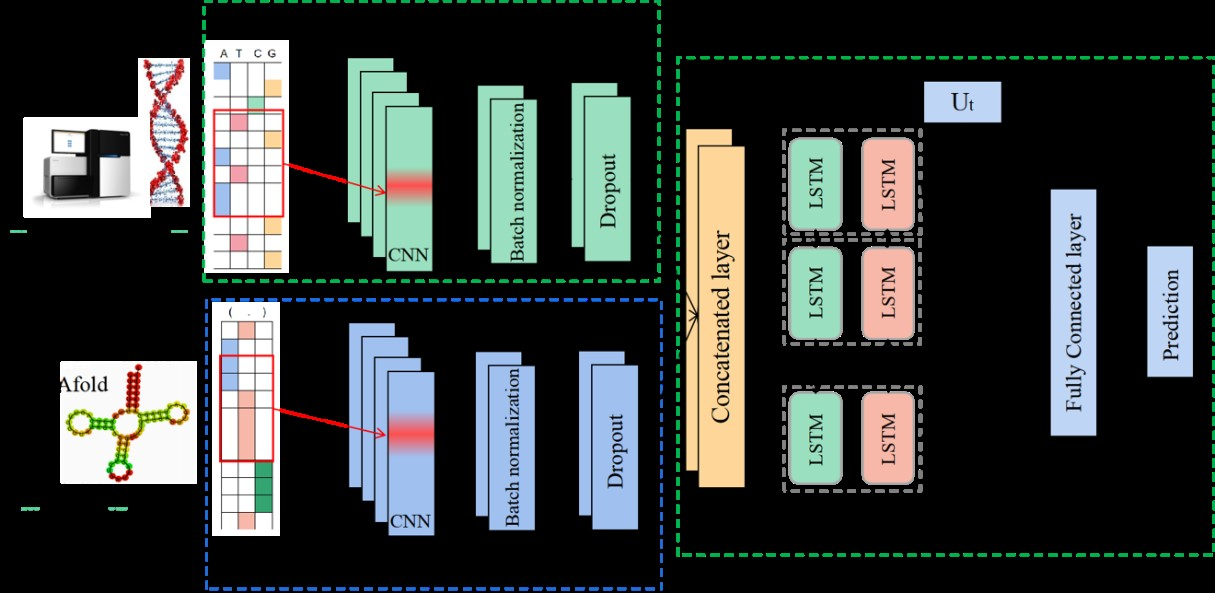

|<font size=3>hyper-parameters|<font size=3>value|<font size=3>hyper-parameters|<font size=3>value|
|:-:|:-:|:-:|:-:|
|<font size=3>con1st_filters|<font size=3>128|<font size=3>con1st_kernel_size|<font size=3>11|
|<font size=3>con2nd_filters|<font size=3>64|<font size=3>con1st_kernel_size|<font size=3>5|
|<font size=3>dropout|<font size=3>0.0005|<font size=3>hidden_size|<font size=3>128|
|<font size=3>opsize|<font size=3>128|<font size=3>learning_rate|<font size=3>0.001|

<font size=3>In order to evaluate the effect of introducing secondary structure information, the following model does not contain secondary structure information.

## Model test

<font size=3>Evaluate the model performance, draw the training, validation loss and accuracy respectively. Test the model performance, use the following evaluation metrics.

$$Sp=\frac{TN}{TN+FP}$$

$$Sn=Recall=\frac{TP}{TP+FN}$$

$$Acc=\frac{TP+TN}{TP+FP+TN+FN}$$

$$Precision=\frac{TP}{TP+FP}$$

$$F1 score=\frac{2\times Precision\times Recall}{Precision+Recall}$$

<font size=3>In addition to the above metrics, the **Receiver Operating Characteristic Curve** (ROC) is also adopted to evaluate the model proposed in this paper. This evaluation method can judge the model's merits by the area enclosed by the curve and the coordinate axis, and both positive and negative samples can be taken into account. It is suitable for evaluating the overall performance of the model. Generally speaking, the larger the enclosed area, the better the model's performance. Apart from ROC, the model was also evaluated using a **Precision-Recall Curve** (PR). This metric focuses more on positive sample prediction cases and is suitable for evaluating model performance under different class distributions. Generally, the model represented by the curve at the top of the method is better than the model at the bottom.

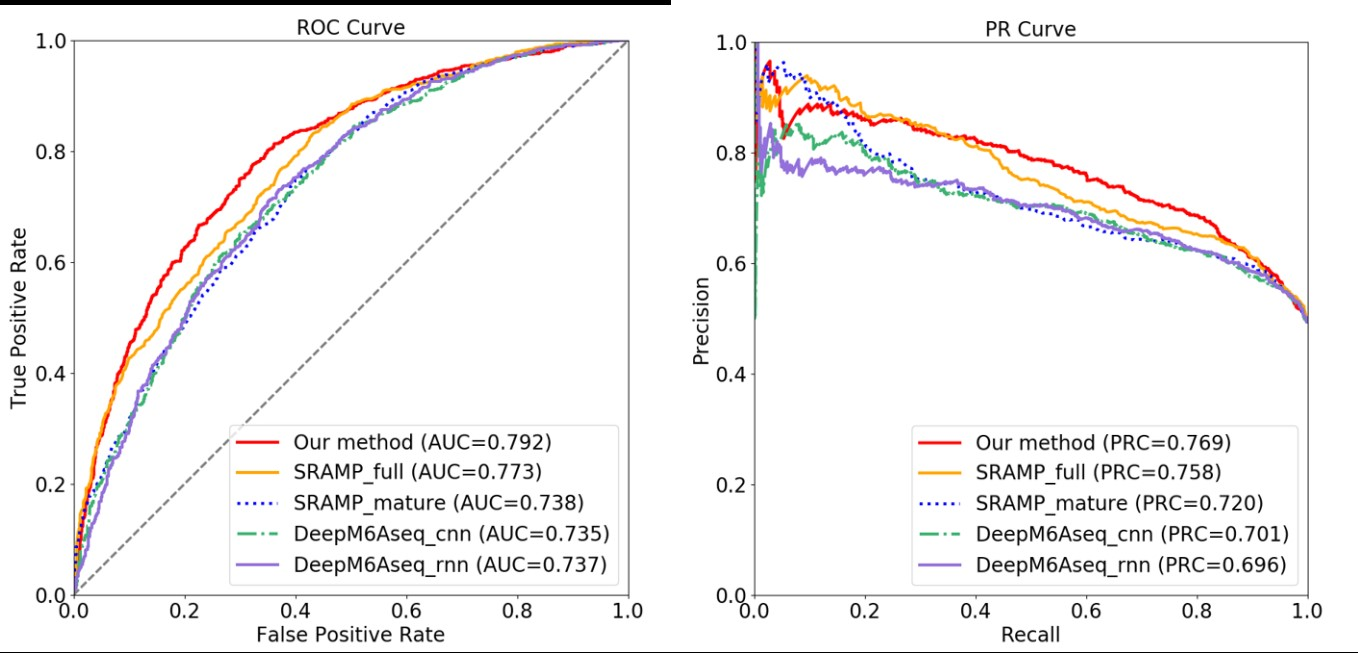

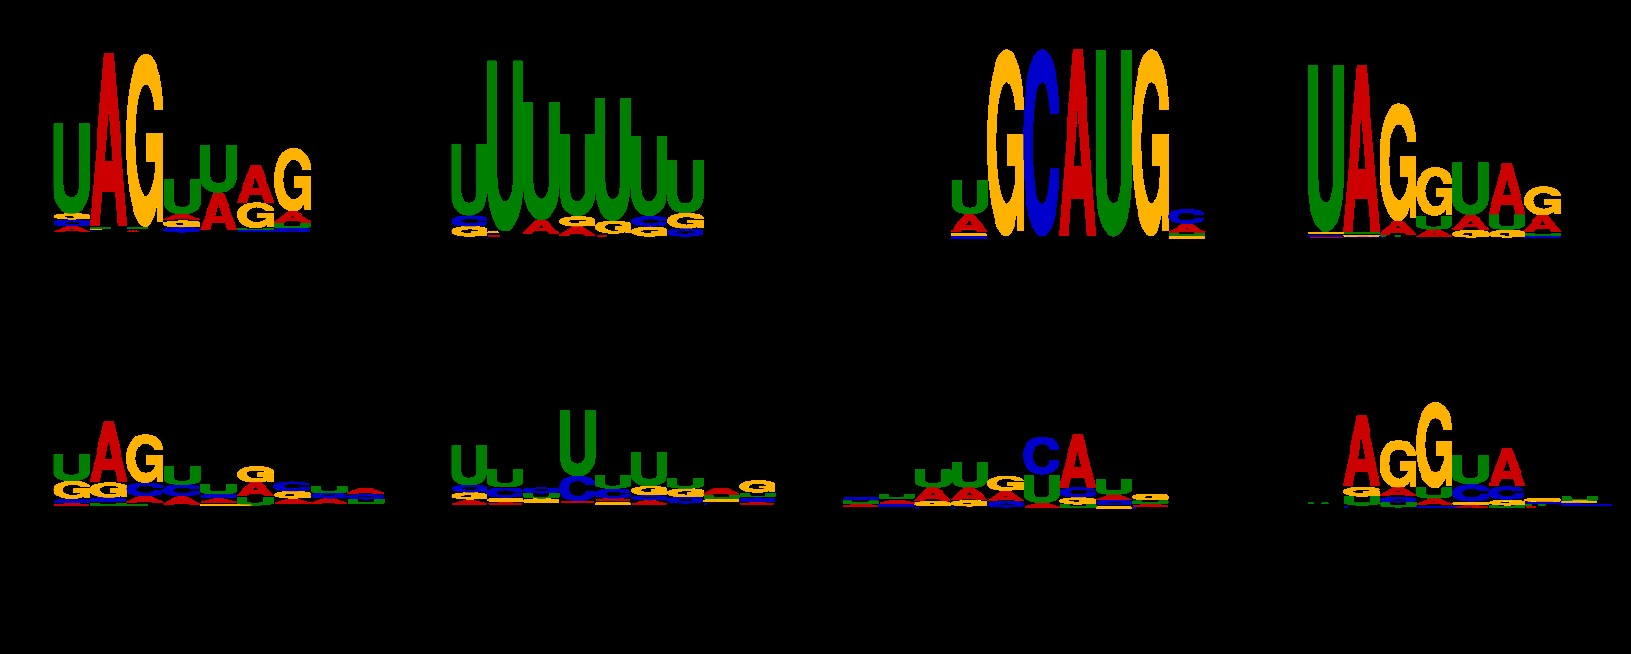